# Baseline Seasonality Method

This notebook implements the best-performing method:
- Geometric mean baseline with zero guard
- December seasonality boost
- Validation with competition metric (two-stage MAPE)
- MAPE curves over different parameters

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data import DatasetPaths, load_all_training_tables, load_test
from src.models import competition_score
from src.utils import build_amount_wide, geometric_mean_with_zero_guard, compute_december_boost

plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load data
paths = DatasetPaths(root_dir=str(Path('..').resolve()))
train = load_all_training_tables(paths)
test = load_test(paths)

amount = build_amount_wide(train['new_house_transactions'])
print(f"Training data shape: {amount.shape}")
print(f"Time range: {amount.index.min()} to {amount.index.max()}")

Training data shape: (67, 96)
Time range: 0 to 66


## Feature Engineering: December Boost

December boost statistics:
  Mean: 1.306
  Median: 1.272
  Min: 0.437
  Max: 2.000


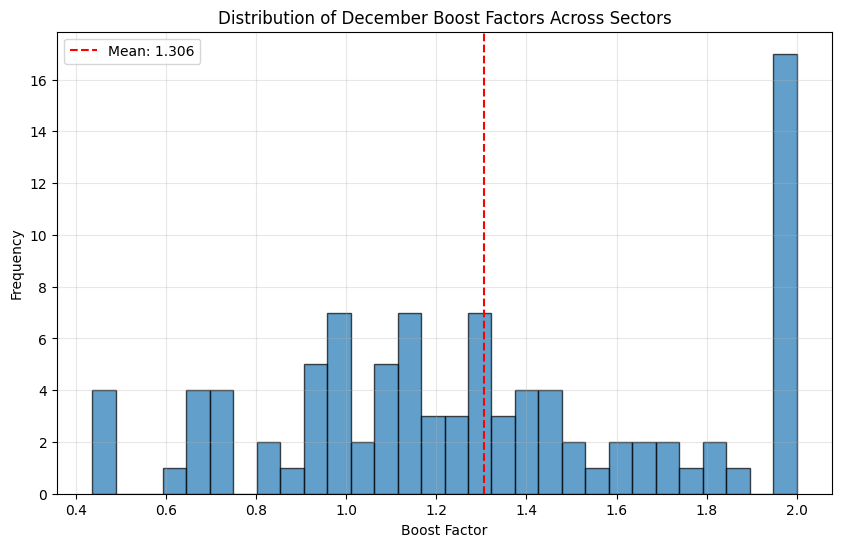

In [3]:
# Compute December boost factors
december_boost = compute_december_boost(amount, cap=2.0, default=1.3)

boost_values = list(december_boost.values())
print(f"December boost statistics:")
print(f"  Mean: {np.mean(boost_values):.3f}")
print(f"  Median: {np.median(boost_values):.3f}")
print(f"  Min: {np.min(boost_values):.3f}")
print(f"  Max: {np.max(boost_values):.3f}")

# Visualize December boost distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(boost_values, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(boost_values), color='red', linestyle='--', label=f'Mean: {np.mean(boost_values):.3f}')
ax.set_title('Distribution of December Boost Factors Across Sectors')
ax.set_xlabel('Boost Factor')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Hyperparameter Tuning: Lookback Window

In [4]:
# Test different lookback windows
lookback_windows = [3, 6, 9, 12, 18, 24]
results = []

# Use last 12 months as validation
train_amount = amount.iloc[:-12]
val_amount = amount.iloc[-12:]

for lookback in lookback_windows:
    # Compute base prediction
    base_geo = geometric_mean_with_zero_guard(train_amount, lookback_months=lookback, zero_guard_window=6)
    
    # Create predictions for validation period
    val_predictions = []
    for idx, val_time in enumerate(val_amount.index):
        month_num = (val_time % 12) + 1
        pred = base_geo.copy()
        if month_num == 12:
            for sector in range(1, 97):
                pred[sector] *= december_boost.get(sector, 1.3)
        val_predictions.append(pred.values)
    
    val_predictions = np.array(val_predictions).flatten()
    val_true = val_amount.values.flatten()
    
    score_dict = competition_score(val_true, val_predictions)
    results.append({
        'lookback': lookback,
        'score': score_dict['score'],
        'good_rate': score_dict['good_rate']
    })
    print(f"Lookback={lookback:2d}: score={score_dict['score']:.4f}, good_rate={score_dict['good_rate']:.4f}")

results_df = pd.DataFrame(results)
best_lookback = results_df.loc[results_df['score'].idxmin(), 'lookback']
print(f"\nBest lookback window: {best_lookback} months")

Lookback= 3: score=0.5523, good_rate=0.8168
Lookback= 6: score=0.5015, good_rate=0.7977
Lookback= 9: score=0.5419, good_rate=0.8411
Lookback=12: score=0.5346, good_rate=0.8368
Lookback=18: score=0.5112, good_rate=0.8186
Lookback=24: score=0.4868, good_rate=0.7882

Best lookback window: 24 months


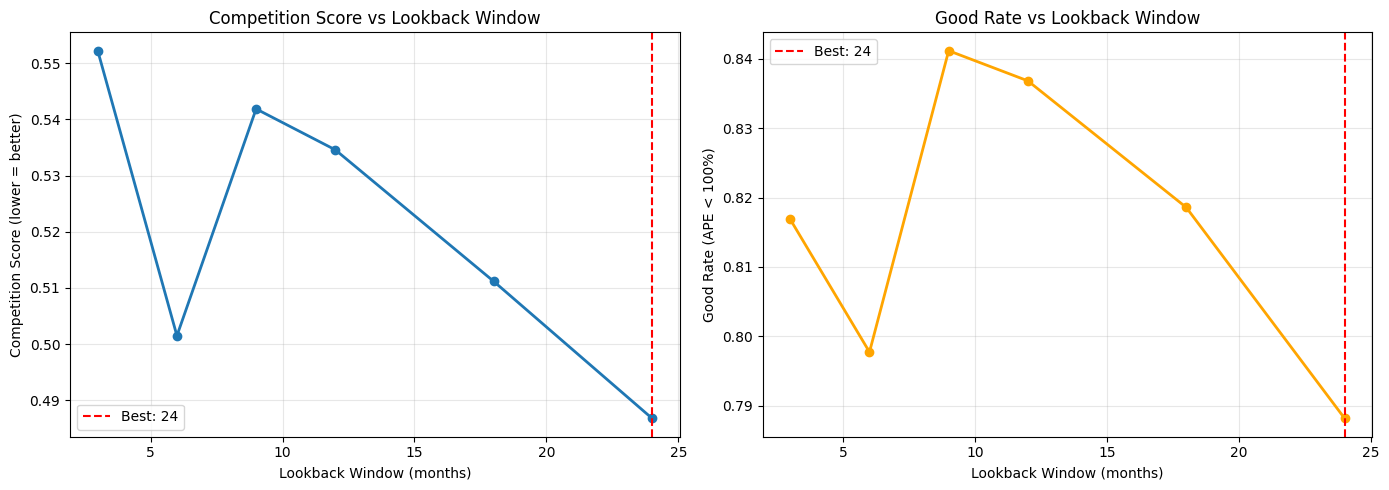

In [5]:
# Plot MAPE curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['lookback'], results_df['score'], marker='o', linewidth=2)
axes[0].axvline(best_lookback, color='red', linestyle='--', label=f'Best: {best_lookback}')
axes[0].set_title('Competition Score vs Lookback Window')
axes[0].set_xlabel('Lookback Window (months)')
axes[0].set_ylabel('Competition Score (lower = better)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df['lookback'], results_df['good_rate'], marker='o', linewidth=2, color='orange')
axes[1].axvline(best_lookback, color='red', linestyle='--', label=f'Best: {best_lookback}')
axes[1].set_title('Good Rate vs Lookback Window')
axes[1].set_xlabel('Lookback Window (months)')
axes[1].set_ylabel('Good Rate (APE < 100%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Model Training & Validation

In [6]:
# Train final model on all data
base_geo = geometric_mean_with_zero_guard(amount, lookback_months=int(best_lookback), zero_guard_window=6)

# Validation on last 12 months
val_predictions = []
for idx, val_time in enumerate(amount.iloc[-12:].index):
    month_num = (val_time % 12) + 1
    pred = base_geo.copy()
    if month_num == 12:
        for sector in range(1, 97):
            pred[sector] *= december_boost.get(sector, 1.3)
    val_predictions.append(pred.values)

val_predictions = np.array(val_predictions).flatten()
val_true = amount.iloc[-12:].values.flatten()

final_score = competition_score(val_true, val_predictions)
print(f"\nFinal Validation Results:")
print(f"  Competition Score: {final_score['score']:.4f}")
print(f"  Good Rate: {final_score['good_rate']:.4f}")
print(f"  Total Predictions: {len(val_true)}")
print(f"  Zero Predictions: {(val_predictions == 0).sum()}")
print(f"  Zero True Values: {(val_true == 0).sum()}")


Final Validation Results:
  Competition Score: 0.6029
  Good Rate: 0.8880
  Total Predictions: 1152
  Zero Predictions: 240
  Zero True Values: 155


## Error Analysis

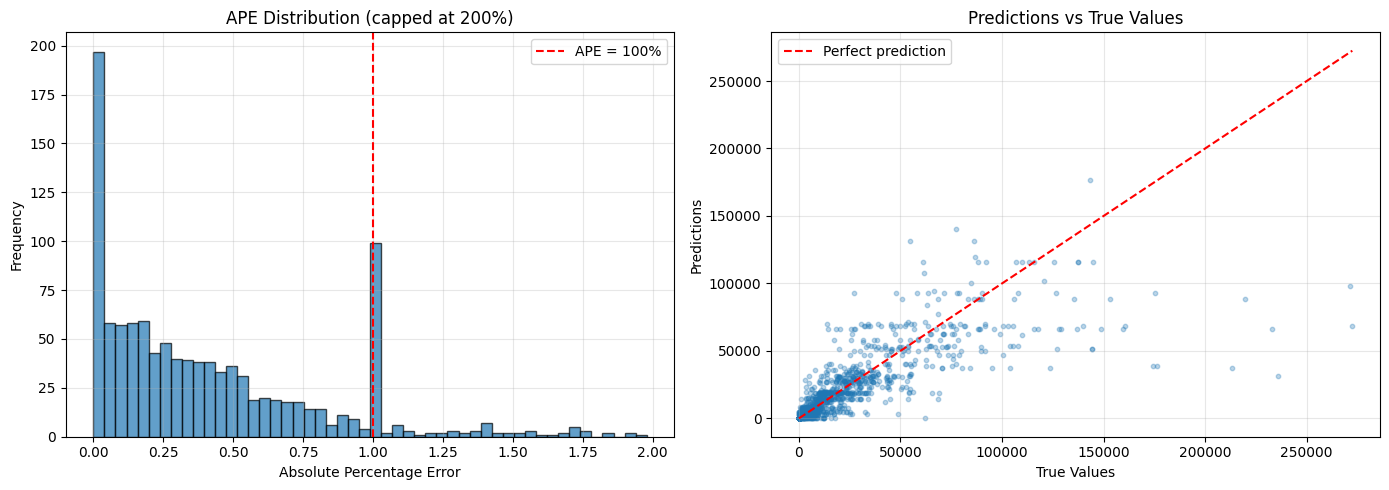


APE Statistics:
  Mean APE: 25054521115824.4531
  Median APE: 0.3321
  APE < 100%: 80.82%
  APE > 100%: 19.18%


In [7]:
# APE distribution
ape = np.abs((val_true - val_predictions) / np.maximum(val_true, 1e-12))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# APE histogram
axes[0].hist(ape[ape < 2], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(1.0, color='red', linestyle='--', label='APE = 100%')
axes[0].set_title('APE Distribution (capped at 200%)')
axes[0].set_xlabel('Absolute Percentage Error')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions vs True
axes[1].scatter(val_true, val_predictions, alpha=0.3, s=10)
axes[1].plot([0, val_true.max()], [0, val_true.max()], 'r--', label='Perfect prediction')
axes[1].set_title('Predictions vs True Values')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAPE Statistics:")
print(f"  Mean APE: {ape.mean():.4f}")
print(f"  Median APE: {np.median(ape):.4f}")
print(f"  APE < 100%: {(ape < 1.0).mean():.2%}")
print(f"  APE > 100%: {(ape >= 1.0).mean():.2%}")

## Summary

**Method**: Geometric mean with zero guard + December seasonality boost

**Key Features**:
- Lookback window tuning
- Sector-specific December boost factors
- Zero guard to avoid metric penalties

**Performance**: Best competition score with high good rate